In [ ]:

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

#do not show warnings
import warnings
warnings.filterwarnings("ignore")
from chart_studio import plotly as py
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split



In [93]:
import plotly.graph_objects as go
import plotly.offline as pyoff
import chart_studio.plotly as py


In [145]:
import pandas as pd
df = pd.read_parquet('sample_txn_data_2022.parquet', engine='pyarrow')

In [146]:
df.to_csv("sample",index=False)

In [147]:
df = pd.read_csv("sample.csv")

In [148]:
df.tail()

,dw_gc_header,business_date,fiscal_week_end,fiscal_week,fiscal_year,daypart_name,lineitem_sequence,lineitem_seq_parent,lineitem_description,parent_product_description,...,actmodqty,actdiscqty,actprodprice,actgrosssales,actnetsales,actpromosales,actdiscsales,acttax,dw_gc_header_2,token_primary_account_identifier
1974583,50128929153,2022-12-24,2022-12-27,Y2022 Q04 P13 W04,Y2022,AFTERNOON,1,1,NON-COMBO-ITEM,7 Lyr Fry Bur,...,0.0,0.0,3.49,3.49,3.49,0.0,0.0,0.00,50128929153,8175776638681170
1974584,50128929153,2022-12-24,2022-12-27,Y2022 Q04 P13 W04,Y2022,AFTERNOON,6,5,NON-COMBO-M-INGRD-MINUS,Dbl Stk GrCh Bur,...,1.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,50128929153,8175776638681170
1974585,50128929153,2022-12-24,2022-12-27,Y2022 Q04 P13 W04,Y2022,AFTERNOON,5,5,NON-COMBO-ITEM,Dbl Stk GrCh Bur,...,0.0,0.0,6.40,6.40,6.40,0.0,0.0,0.00,50128929153,8175776638681170
1974586,50128929153,2022-12-24,2022-12-27,Y2022 Q04 P13 W04,Y2022,AFTERNOON,7,7,NON-COMBO-ITEM,Water,...,0.0,0.0,0.10,0.10,0.10,0.0,0.0,0.00,50128929153,8175776638681170
1974587,50128929153,2022-12-24,2022-12-27,Y2022 Q04 P13 W04,Y2022,AFTERNOON,999,999,TAX-LINE,NaN,...,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.92,50128929153,8175776638681170


In [149]:
df = df.drop(["fiscal_week_end","fiscal_year","lineitem_sequence",\
      "lineitem_seq_parent","lineitem_description","dw_gc_header_2","acttax","fiscal_week","parent_product_code"\
             ,"child_product_code","modification_product_code","actgrosssales","actnetsales","actdiscsales"\
             ,"actpromosales"],1)

In [150]:
tx_data = df.drop(["child_product_description","modification_description","actpromoqty","actmodqty","actdiscqty"],1)

In [151]:
tx_data.head()

,dw_gc_header,business_date,daypart_name,parent_product_description,actqtysold,actprodprice,token_primary_account_identifier
0,42188263563,2021-12-31,EVENING,NaN,0.0,0.00,880344659239910
1,42188263563,2021-12-31,EVENING,Beefy 5-Layer Burrito,1.0,2.99,880344659239910
2,42188263563,2021-12-31,EVENING,Cheesy Bean and Rice Burrito,1.0,1.29,880344659239910
3,42201144646,2021-12-31,BREAKFAST,NaN,0.0,0.00,8819419820104328
4,42201144646,2021-12-31,BREAKFAST,Breakfast Crunchwrap - Bacon,1.0,3.49,8819419820104328


In [152]:
tx_data = tx_data.rename(columns={'dw_gc_header': 'InvoiceNo', 'parent_product_description': 'Description',"actqtysold":"Quantity","business_date"\
                       :"InvoiceDate","actprodprice":"UnitPrice","token_primary_account_identifier":"CustomerID","daypart_name"\
                                 :"StockCode"})

In [153]:
tx_data.head()

,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,CustomerID
0,42188263563,2021-12-31,EVENING,NaN,0.0,0.00,880344659239910
1,42188263563,2021-12-31,EVENING,Beefy 5-Layer Burrito,1.0,2.99,880344659239910
2,42188263563,2021-12-31,EVENING,Cheesy Bean and Rice Burrito,1.0,1.29,880344659239910
3,42201144646,2021-12-31,BREAKFAST,NaN,0.0,0.00,8819419820104328
4,42201144646,2021-12-31,BREAKFAST,Breakfast Crunchwrap - Bacon,1.0,3.49,8819419820104328


In [154]:
tx_data.tail()

,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,CustomerID
1974583,50128929153,2022-12-24,AFTERNOON,7 Lyr Fry Bur,1.0,3.49,8175776638681170
1974584,50128929153,2022-12-24,AFTERNOON,Dbl Stk GrCh Bur,0.0,0.00,8175776638681170
1974585,50128929153,2022-12-24,AFTERNOON,Dbl Stk GrCh Bur,1.0,6.40,8175776638681170
1974586,50128929153,2022-12-24,AFTERNOON,Water,1.0,0.10,8175776638681170
1974587,50128929153,2022-12-24,AFTERNOON,NaN,0.0,0.00,8175776638681170


In [155]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate']).dt.date

In [156]:
tx_data["InvoiceDate"].unique()

array([datetime.date(2021, 12, 31), datetime.date(2022, 1, 1),
       datetime.date(2022, 1, 2), datetime.date(2021, 12, 29),
       datetime.date(2021, 12, 30), datetime.date(2022, 1, 3),
       datetime.date(2022, 1, 4), datetime.date(2022, 1, 5),
       datetime.date(2022, 1, 6), datetime.date(2022, 1, 7),
       datetime.date(2022, 1, 8), datetime.date(2022, 1, 9),
       datetime.date(2022, 1, 10), datetime.date(2022, 1, 11),
       datetime.date(2022, 1, 12), datetime.date(2022, 1, 13),
       datetime.date(2022, 1, 14), datetime.date(2022, 1, 15),
       datetime.date(2022, 1, 16), datetime.date(2022, 1, 17),
       datetime.date(2022, 1, 18), datetime.date(2022, 1, 21),
       datetime.date(2022, 1, 22), datetime.date(2022, 1, 23),
       datetime.date(2022, 1, 19), datetime.date(2022, 1, 20),
       datetime.date(2022, 1, 24), datetime.date(2022, 1, 25),
       datetime.date(2022, 1, 26), datetime.date(2022, 1, 27),
       datetime.date(2022, 1, 28), datetime.date(2022, 1, 29)

In [157]:
tx_data['InvoiceDate'][1]> date(2022,6,1)

False

In [158]:
## data partition
tx_6m = tx_data[(tx_data.InvoiceDate < date(2022,6,1)) & \
                (tx_data.InvoiceDate >= date(2021,12,31))].reset_index(drop=True)
tx_next = tx_data[(tx_data.InvoiceDate >= date(2022,6,1)) & \
                  (tx_data.InvoiceDate < date(2022,12,1))].reset_index(drop=True)

## find differenct between the first purchase and last purchase

In [159]:
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID'] 

In [160]:
#create a dataframe with customer id and first purchase date in tx_next
tx_next_first_purchase = tx_next.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

#create a dataframe with customer id and last purchase date in tx_6m
tx_last_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

#merge two dataframes
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='CustomerID',how='left')

#calculate the time difference in days:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days

#merge with tx_user 
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

#print tx_user
tx_user.head()

#fill NA values with 999
tx_user = tx_user.fillna(999)

In [161]:
tx_user.head()

,CustomerID,NextPurchaseDay
0,880344659239910,125.0
1,8819419820104328,26.0
2,8456488655739252,69.0
3,8504411087099781,11.0
4,761848206682093,115.0


In [162]:
#get max purchase date for Recency and create a dataframe
tx_max_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#find the recency in days and add it to tx_user
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

#plot recency
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
 )
]

plot_layout = go.Layout(
        title='Recency'
 )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#clustering for Recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
return df_final


#order recency clusters
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#print cluster characteristics
tx_user.groupby('RecencyCluster')['Recency'].describe()


#get total purchases for frequency scores
tx_frequency = tx_6m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

#add frequency column to tx_user
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

#plot frequency
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
 )
]

plot_layout = go.Layout(
        title='Frequency'
 )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#clustering for frequency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order frequency clusters and show the characteristics
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user.groupby('FrequencyCluster')['Frequency'].describe()


#calculate monetary value, create a dataframe with it
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_revenue = tx_6m.groupby('CustomerID').Revenue.sum().reset_index()

#add Revenue column to tx_user
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

#plot Revenue
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
 )
]

plot_layout = go.Layout(
        title='Monetary Value'
 )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Revenue clusters 
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

#ordering clusters and who the characteristics
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)
tx_user.groupby('RevenueCluster')['Revenue'].describe()


#building overall segmentation
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

#assign segment names
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

#plot revenue vs frequency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
 )
 ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
 )
 ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
 )
 ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
 )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#plot revenue vs recency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
 )
 ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
 )
 ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
 )
 ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
 )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#plot frequency vs recency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
 )
 ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
 )
 ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
 )
 ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
 )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

AttributeError: 'NoneType' object has no attribute 'split'

In [163]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','InvoiceDate']]
#convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['InvoiceDate']
tx_day_order = tx_day_order.sort_values(['CustomerID','InvoiceDate'])
#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

## using shift, find the most recent 3 purchase：

In [164]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [196]:
tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
762045,25069,2022-05-23,2022-05-23,NaN,NaN,NaN,NaN,NaN,NaN
827012,25069,2022-05-31,2022-05-31,2022-05-23,NaN,NaN,8.0,NaN,NaN
728311,95546,2022-05-16,2022-05-16,NaN,NaN,NaN,NaN,NaN,NaN
751159,95546,2022-05-21,2022-05-21,2022-05-16,NaN,NaN,5.0,NaN,NaN
583740,96009,2022-04-14,2022-04-14,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:

tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

In [166]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

In [167]:
tx_day_order_last = tx_day_order.drop_duplicates(subset = ['CustomerID'],keep ='last')

In [168]:
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')
#create tx_class as a copy of tx_user before applying get_dummies
tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)

In [ ]:
##Model!!!!!!

In [169]:
tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0

<AxesSubplot:>

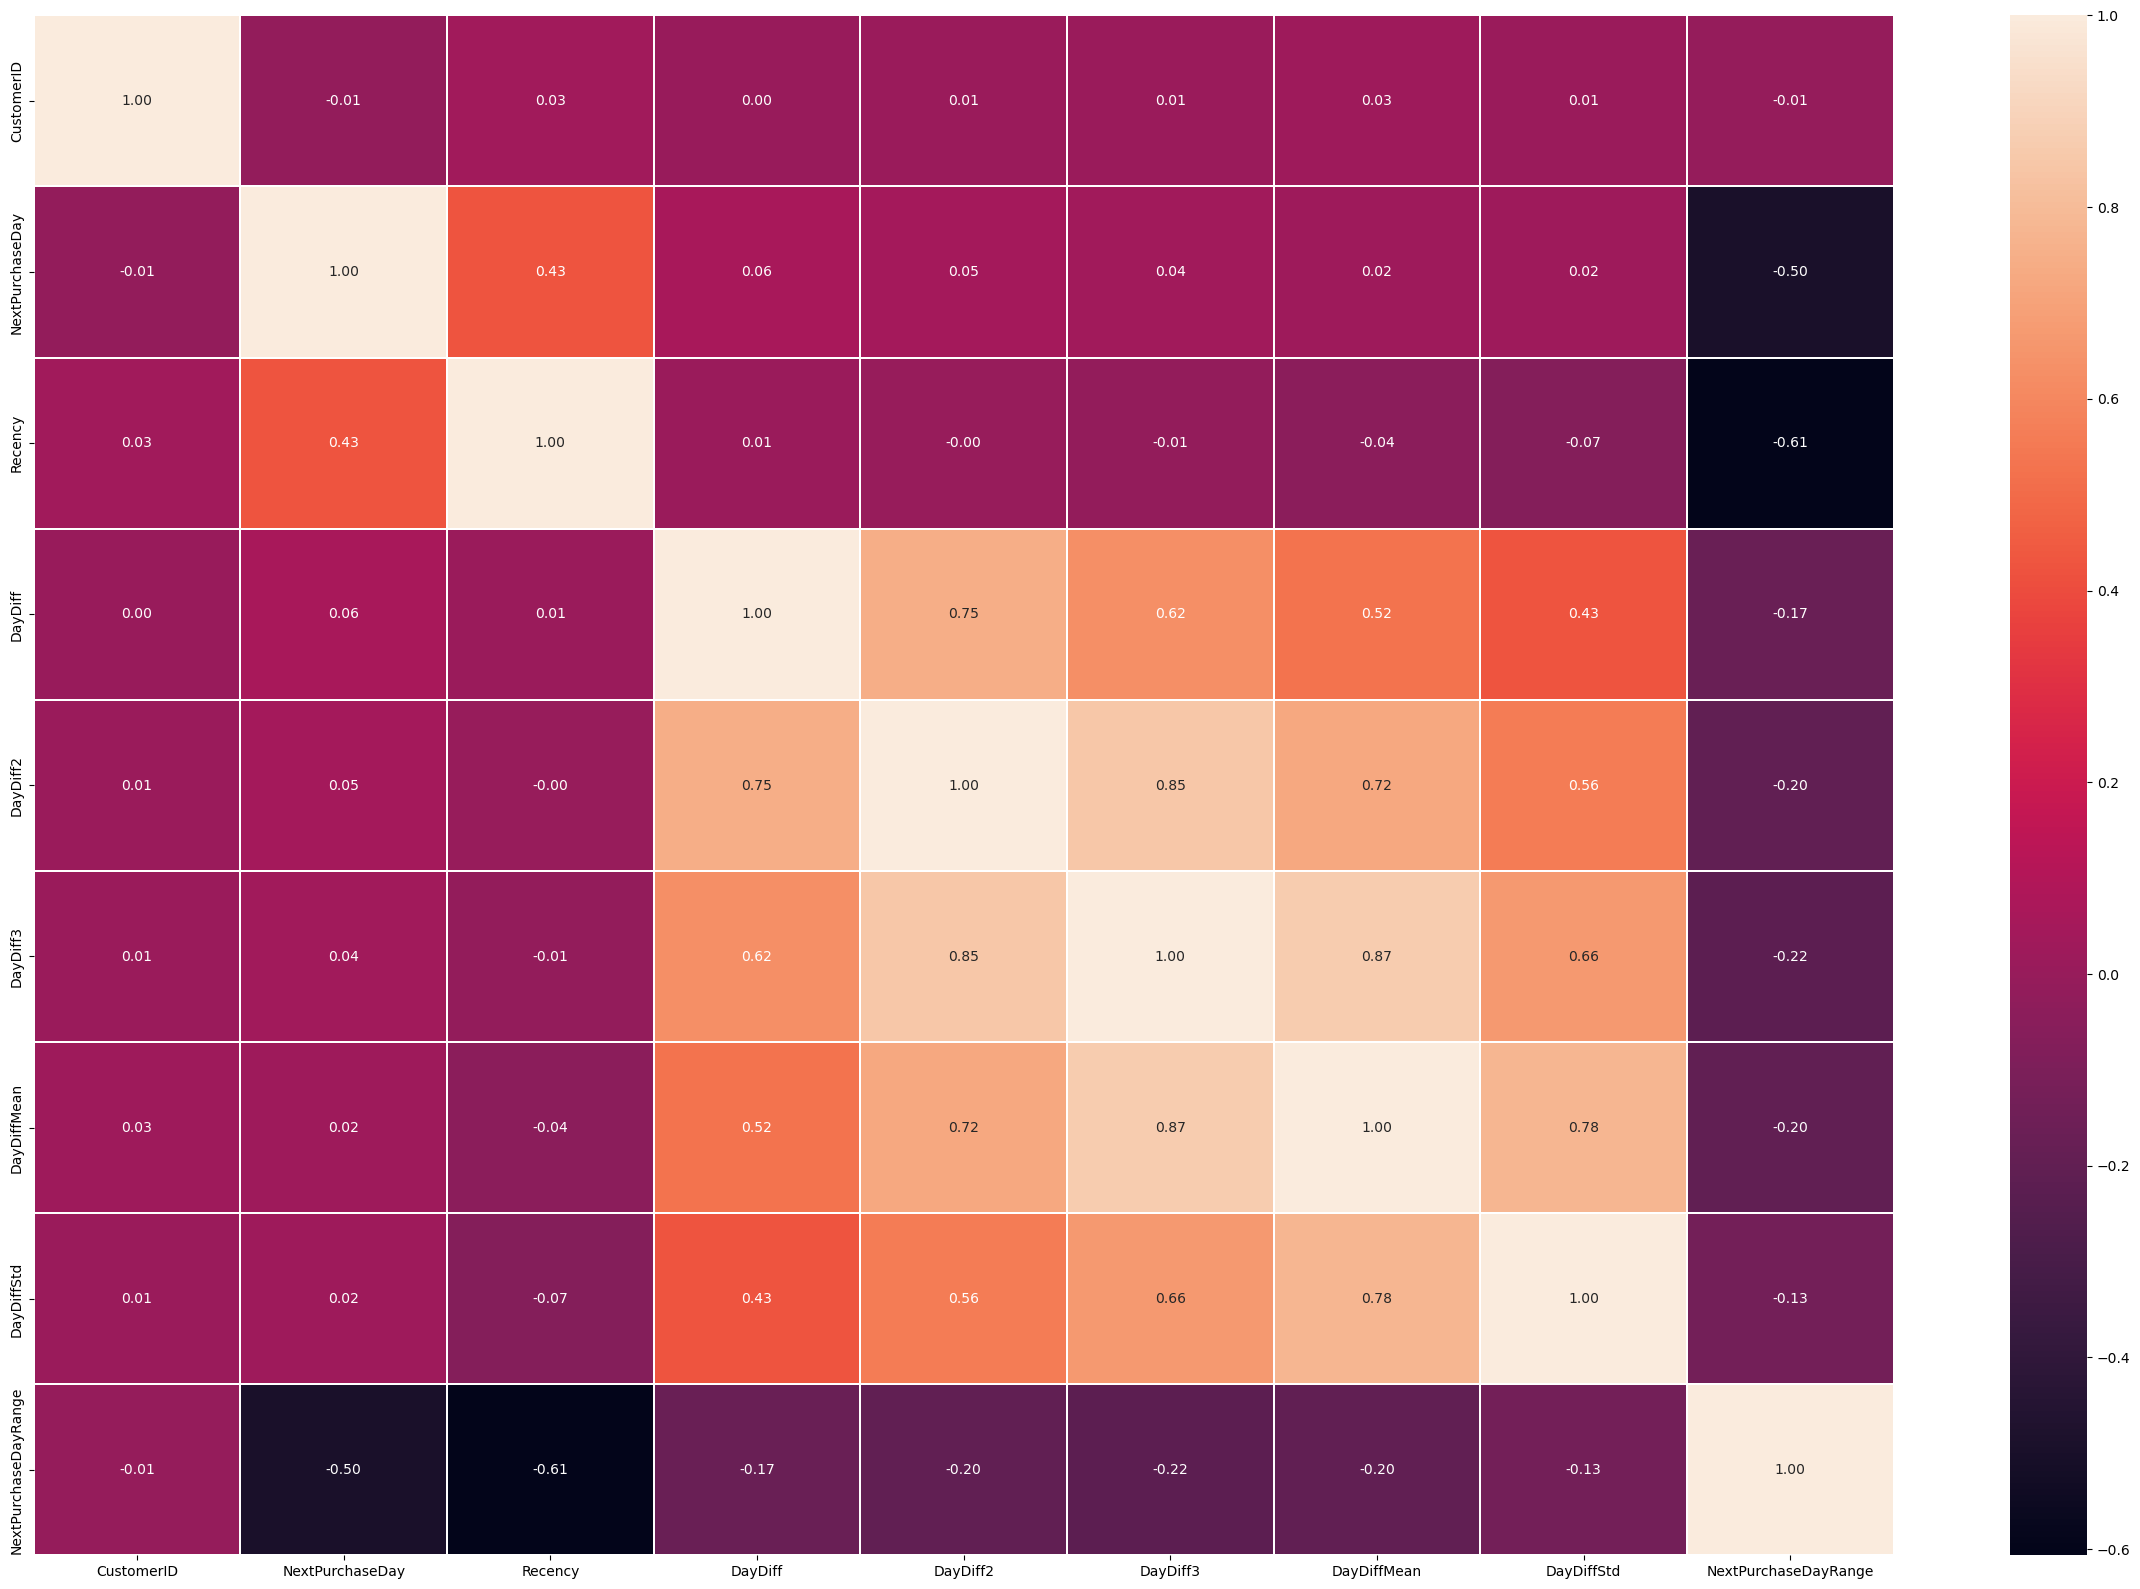

In [170]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [171]:
#train & test split
tx_class = tx_class.drop('NextPurchaseDay',axis=1)
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [172]:

#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))



In [173]:
models[2]

('RF', RandomForestClassifier())

In [175]:
X_train

,CustomerID,Recency,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
920,837253243075882,17,1.0,30.0,127.0,33.250000,44.214440
4213,854714499685318,8,17.0,25.0,45.0,10.750000,4.731423
3810,8095548963516883,13,14.0,26.0,30.0,9.142857,5.289425
6283,203927439877851,9,11.0,12.0,15.0,12.555556,10.701765
8710,859670906283902,4,55.0,60.0,76.0,25.333333,26.274195
...,...,...,...,...,...,...,...
2144,388368689524286,2,37.0,38.0,40.0,14.300000,10.934654
3971,8227392089940571,37,24.0,31.0,38.0,11.111111,12.087643
571,8754844188537216,4,3.0,7.0,9.0,4.741935,5.176664
9389,192911762021436,16,7.0,12.0,20.0,7.000000,1.414214


In [176]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'.format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.64


In [178]:
from sklearn.model_selection import GridSearchCV


In [183]:
## idd not supported, current optimize solution
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy', n_jobs=-1, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.6383252349210273)

In [189]:
## improve 2%.....

xgb_model = xgb.XGBClassifier(max_depth=3,min_child_weight = 1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'.format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.72
Accuracy of XGB classifier on test set: 0.66


In [193]:
xgb_model.predict(X_test)

array([1, 2, 2, ..., 2, 2, 2])